In [1]:
import nltk; nltk.download('stopwords')
# !python3 -m spacy download en
# !python -m spacy download en
!pip install pyLDAvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rmurugan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# Prepare for Stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
# import newsgroups data
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [5]:
# Remove emails and newline characters

# convet to list
data = df.content.values.tolist()

# Remove emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove disstracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [6]:
## Tokenizing and clean up the text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) ## deacc=True removes punctuation

data_words = list(sent_to_words(data))

print(data_words[:2])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst'], ['from', 'guy', 'kuo', 'subje

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [8]:
## Remove stopwords, make bigrams and lemmatize

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  texts_out = []
  for sent in texts:
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.061*"file" + 0.060*"program" + 0.048*"window" + 0.025*"entry" + '
  '0.024*"image" + 0.021*"disk" + 0.020*"run" + 0.020*"screen" + 0.019*"set" + '
  '0.018*"display"'),
 (1,
  '0.028*"people" + 0.024*"say" + 0.015*"would" + 0.014*"think" + '
  '0.013*"reason" + 0.012*"believe" + 0.011*"evidence" + 0.011*"know" + '
  '0.009*"make" + 0.009*"may"'),
 (2,
  '0.100*"key" + 0.059*"government" + 0.058*"public" + 0.029*"encryption" + '
  '0.028*"church" + 0.025*"security" + 0.024*"protect" + 0.024*"private" + '
  '0.022*"crime" + 0.022*"character"'),
 (3,
  '0.708*"ax" + 0.012*"agency" + 0.012*"market" + 0.010*"upgrade" + '
  '0.010*"gift" + 0.010*"cd" + 0.009*"sc" + 0.009*"hell" + 0.005*"own" + '
  '0.004*"brother"'),
 (4,
  '0.108*"line" + 0.077*"write" + 0.046*"article" + 0.035*"host" + '
  '0.033*"nntp_poste" + 0.031*"organization" + 0.026*"be" + 0.026*"know" + '
  '0.023*"would" + 0.021*"thank"'),
 (5,
  '0.084*"com" + 0.068*"distribution" + 0.059*"picture" + 0.058*"office" + '


In [14]:
## Compute model perplexity and coherence score

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.277975111521005

Coherence Score:  0.499899150378291


In [15]:
# Visualize the tpoics-keywords

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.309475  0.051797       1        1  23.909279
1      0.307762  0.097903       2        1  22.052406
10     0.282471  0.182284       3        1  12.228545
4      0.243363 -0.063756       4        1  12.143528
6      0.154776 -0.301398       5        1  11.311726
3     -0.114834  0.009347       6        1   4.809526
0      0.006448 -0.252428       7        1   3.730043
13    -0.097551 -0.052133       8        1   2.177635
2     -0.092935  0.066029       9        1   2.112161
14    -0.070201  0.153251      10        1   1.788417
11    -0.162326 -0.008775      11        1   1.017305
8     -0.184832  0.035449      12        1   0.865939
12    -0.186712  0.048730      13        1   0.794016
7     -0.193599  0.004478      14        1   0.534772
5     -0.201305  0.029222      15        1   0.524699, topic_info=             Term          Freq         Total Category  logprob  loglift
3718           ax  39788.000000  39788.000000  Default  30.0000  30.0000
18           line  15423.000000  15423.000000  Default  29.0000  29.0000
197         write  12860.000000  12860.000000  Default  28.0000  28.0000
112            go   7308.000000   7308.000000  Default  27.0000  27.0000
177       article   7509.000000   7509.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
216   observatory     25.458292     26.716593  Topic15  -5.4839   5.2019
1361      incline     19.855602     21.113937  Topic15  -5.7325   5.1887
1381      vitamin     13.964377     15.222679  Topic15  -6.0844   5.1638
1992  conceivable     13.103653     14.361959  Topic15  -6.1481   5.1584
2171       object    234.542831    376.771973  Topic15  -3.2633   4.7761

[718 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1227      2  0.998302     accept
80        5  0.998081     access
1594      2  0.998787     action
175       4  0.138161    address
175       5  0.860964    address
...     ...       ...        ...
197       4  0.849487      write
39        1  0.381111       year
39        3  0.609521       year
39       10  0.009008       year
722       3  0.992083  yesterday

[997 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 11, 5, 7, 4, 1, 14, 3, 15, 12, 9, 13, 8, 6])

In [36]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip
# mallet_path = 'C:\\Users\\rmurugan\\nlpmallet-2.0.8\\bin\\mallet\\mallet.bat' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [37]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 2E2C-3EA4

 Directory of C:\Users\rmurugan\nlp

2020-10-19  10:16 PM    <DIR>          .
2020-10-19  10:16 PM    <DIR>          ..
2020-10-19  09:13 PM    <DIR>          .ipynb_checkpoints
2020-10-19  10:07 PM    <DIR>          mallet-2.0.8
2020-10-19  10:16 PM           149,008 topicModelling.ipynb
               1 File(s)        149,008 bytes
               4 Dir(s)  170,643,214,336 bytes free


In [38]:
# !dir mallet-2.0.8\\bin
# C:\\Users\\rmurugan\\nlpmallet-2.0.8\\bin\\mallet

In [40]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(7,
  [('chip', 0.1590592),
   ('bit', 0.08502612),
   ('bus', 0.052444763),
   ('scsi', 0.04892842),
   ('direct', 0.047933534),
   ('ide', 0.033176),
   ('reliable', 0.022042625),
   ('nntp_posting', 0.02104508),
   ('daughter', 0.019738613),
   ('compression', 0.01602752)]),
 (5,
  [('com', 0.08351721),
   ('distribution', 0.067703746),
   ('picture', 0.058671534),
   ('office', 0.05847105),
   ('object', 0.03826139),
   ('frame', 0.024857951),
   ('unlikely', 0.023364466),
   ('corporation', 0.021947483),
   ('expansion', 0.02182262),
   ('confirm', 0.019920941)]),
 (12,
  [('gun', 0.13408431),
   ('fire', 0.05643083),
   ('police', 0.043564778),
   ('notice', 0.04232423),
   ('weapon', 0.041240703),
   ('shoot', 0.039761223),
   ('firearm', 0.03081811),
   ('boy', 0.029432932),
   ('cop', 0.028001994),
   ('rational', 0.027678367)]),
 (14,
  [('kill', 0.035701197),
   ('israeli', 0.02994488),
   ('war', 0.028453993),
   ('soldier', 0.026708812),
   ('lebanese', 0.025596483),
   (

In [41]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [42]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

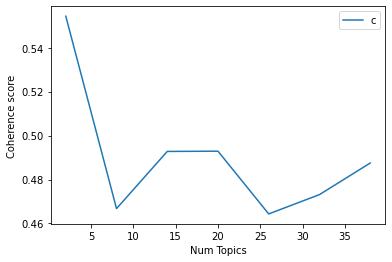

In [43]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()